#Loading data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Importing libraries and initalising directories

In [ ]:
#importing libraries

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

#Visualising data

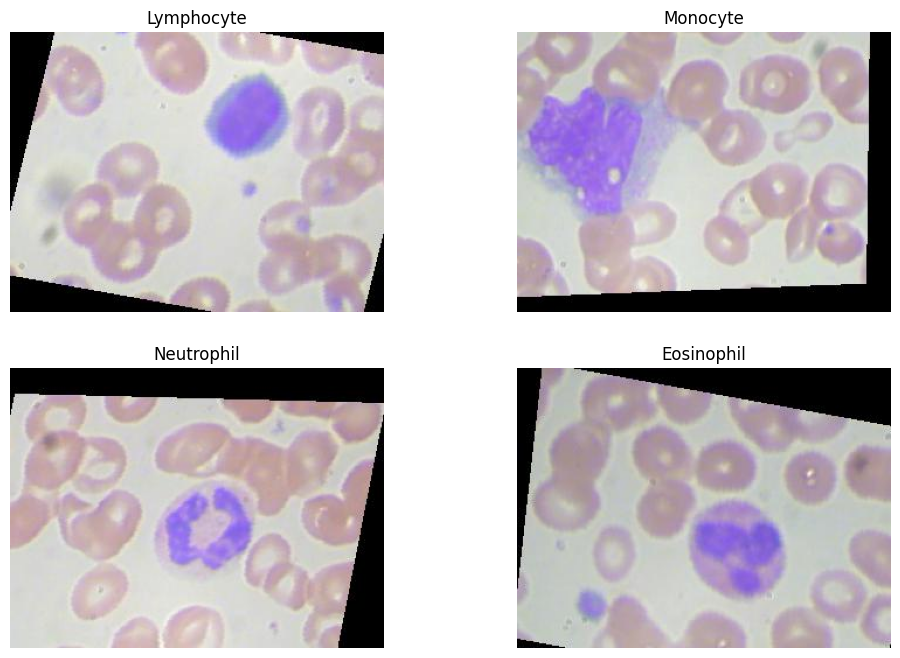

In [ ]:
# Ploting Image
def plotImage(image_path):
    image = cv2.imread(image_path)  # BGR
    image = image[:, :, [2, 1, 0]]  # Reorder to RGB for Matplotlib display
    plt.imshow(image)
    return

#plotting an image for each of the cell types
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.title('Lymphocyte'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/LYMPHOCYTE/_0_204.jpeg'))
plt.subplot(222)
plt.title('Monocyte'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/MONOCYTE/_0_9309.jpeg'))
plt.subplot(223)
plt.title('Neutrophil'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/NEUTROPHIL/_0_9742.jpeg'))
plt.subplot(224)
plt.title('Eosinophil'); plt.axis('off'); plotImage(os.path.join(in_dir, 'TRAIN/EOSINOPHIL/_5_907.jpeg'))

In [ ]:
#Data information

EOSINOPHIL_dirs = [r'/content/drive/MyDrive/ML_project/ML/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL']

LYMPHOCYTE_dir = [r'/content/drive/MyDrive/ML_project/ML/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE']

MONOCYTE_dirs = [r'/content/drive/MyDrive/ML_project/ML/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE']

NEUTROPHIL_dirs = [r'/content/drive/MyDrive/ML_project/ML/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL']

filepaths = []
labels = []
dict_lists = [EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

#making a table for better visualisation
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())

#printing the number of each type in the dataset
print(bloodCell_df["labels"].value_counts())

                                           filepaths      labels
0  /content/drive/MyDrive/ML_project/ML/dataset2-...  EOSINOPHIL
1  /content/drive/MyDrive/ML_project/ML/dataset2-...  EOSINOPHIL
2  /content/drive/MyDrive/ML_project/ML/dataset2-...  EOSINOPHIL
3  /content/drive/MyDrive/ML_project/ML/dataset2-...  EOSINOPHIL
4  /content/drive/MyDrive/ML_project/ML/dataset2-...  EOSINOPHIL
labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64


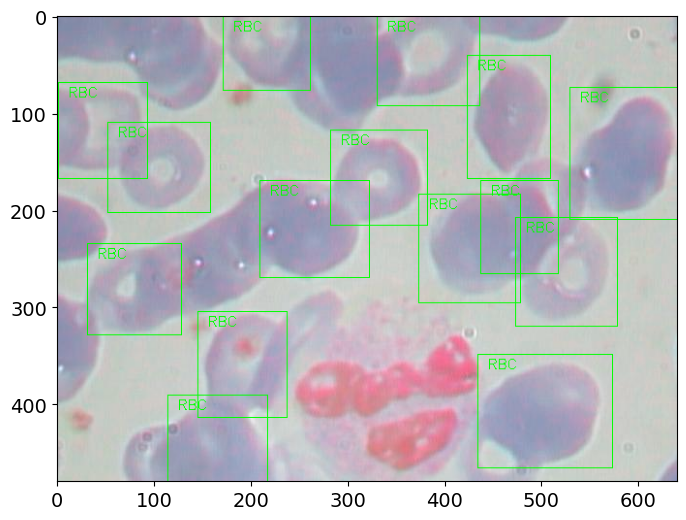

In [ ]:
#visualising what each image looks like, we first identify the RBC and then the unique cell in the image is classified.

image = cv2.imread("/content/drive/MyDrive/ML_project/ML/dataset-master/dataset-master/JPEGImages/BloodImage_00005.jpg") #image
tree = ET.parse("/content/drive/MyDrive/ML_project/ML/dataset-master/dataset-master/Annotations/BloodImage_00005.xml") #annotations for the image

for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
#printing figure
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()

In [ ]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(7965, 2)
(2988, 2)
(1992, 2)
(6969, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

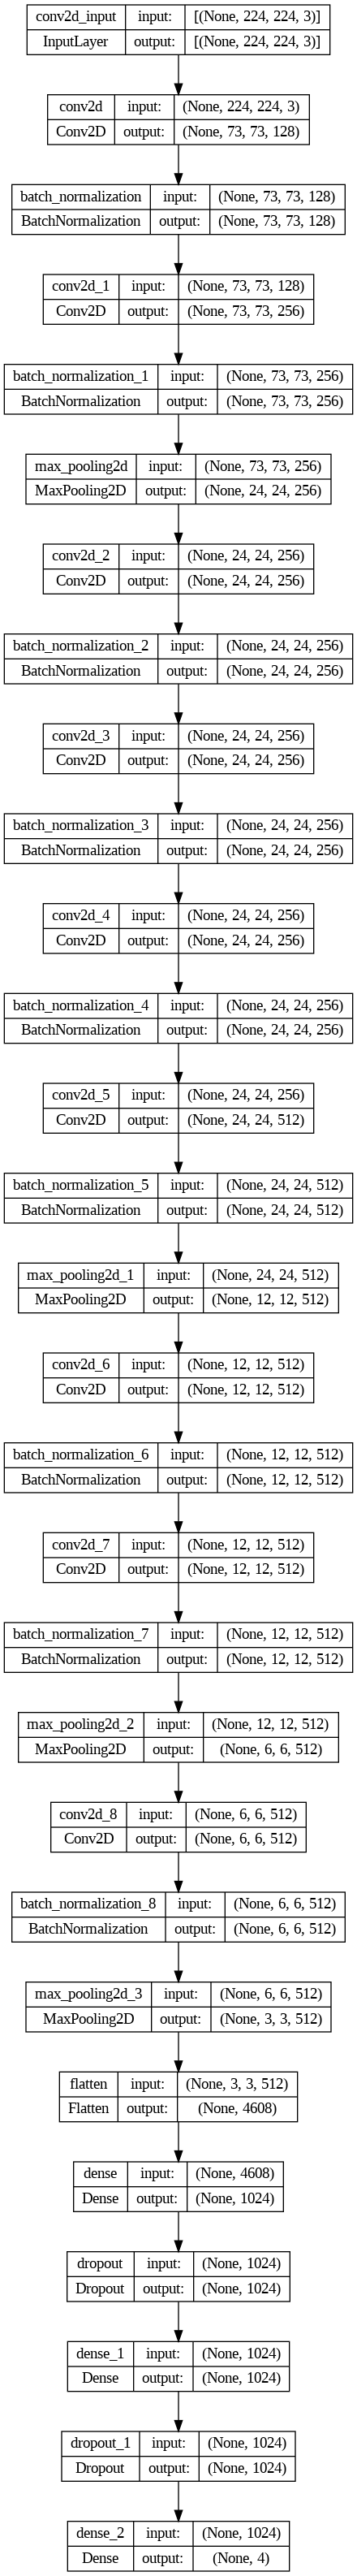

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.9 MB/s eta 0:00:00


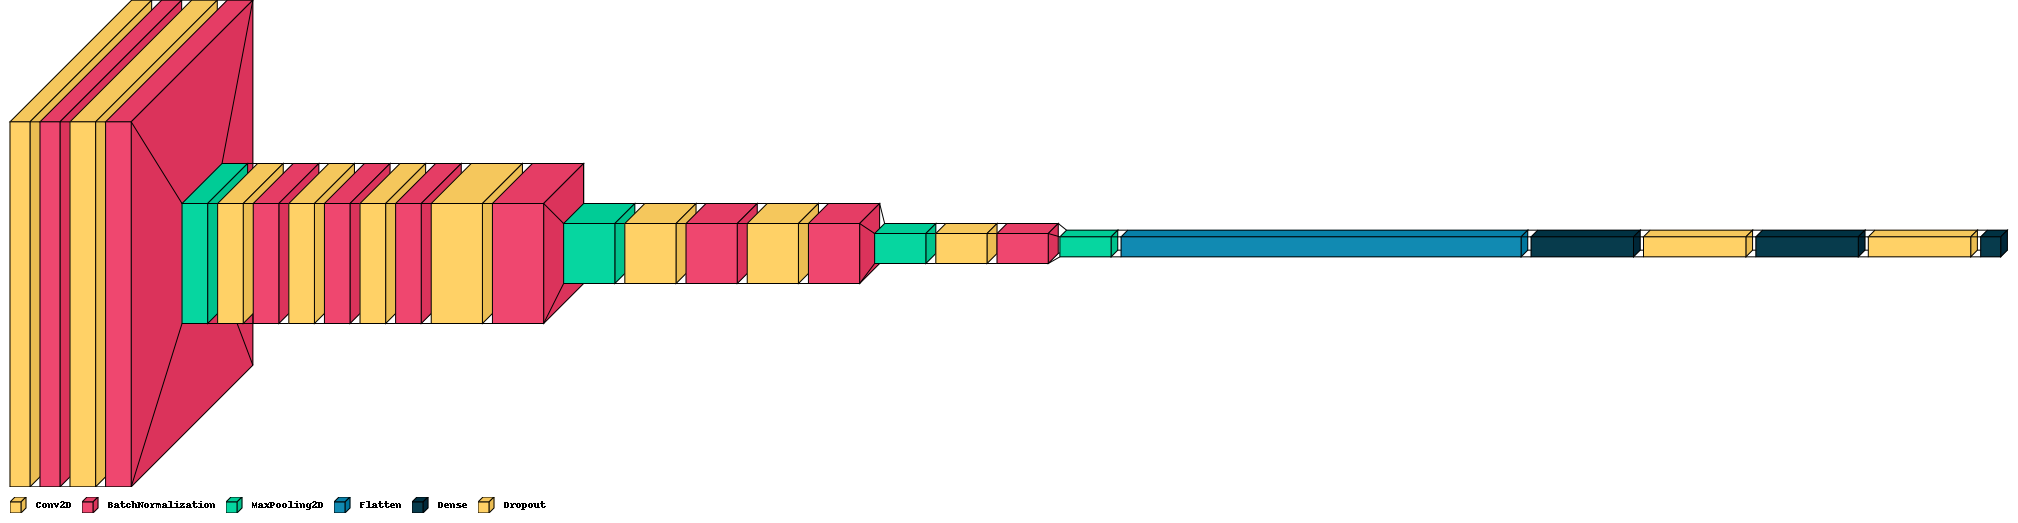

In [ ]:
import visualkeras

visualkeras.layered_view(model, scale_xy=5, legend=True)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
996/996 [==============================] - 131s 113ms/step - loss: 1.6279 - accuracy: 0.3638 - val_loss: 1.0386 - val_accuracy: 0.5457
Epoch 2/10
996/996 [==============================] - 80s 80ms/step - loss: 1.0710 - accuracy: 0.5269 - val_loss: 0.7721 - val_accuracy: 0.6883
Epoch 3/10
996/996 [==============================] - 99s 99ms/step - loss: 0.7568 - accuracy: 0.6771 - val_loss: 0.6849 - val_accuracy: 0.7144
Epoch 4/10
996/996 [==============================] - 101s 101ms/step - loss: 0.5035 - accuracy: 0.7933 - val_loss: 0.3044 - val_accuracy: 0.8735
Epoch 5/10
996/996 [==============================] - 80s 80ms/step - loss: 0.3323 - accuracy: 0.8713 - val_loss: 0.3199 - val_accuracy: 0.8665
Epoch 6/10
996/996 [==============================] - 105s 105ms/step - loss: 0.2617 - accuracy: 0.9011 - val_loss: 0.1597 - val_accuracy: 0.9423
Epoch 7/10
996/996 [==============================] - 94s 94ms/step - loss: 0.1826 - accuracy: 0.9323 - val_loss: 0.1510 - val_acc

In [ ]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

996/996 [==============================] - 84s 84ms/step - loss: 0.0477 - accuracy: 0.9848 - val_loss: 0.1343 - val_accuracy: 0.9523


In [ ]:
model.evaluate(test, verbose=1)

374/374 [==============================] - 18s 49ms/step - loss: 0.1078 - accuracy: 0.9622


[0.1077791303396225, 0.9621820449829102]

In [ ]:
model.save("Blood Cell.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

374/374 [==============================] - 17s 46ms/step


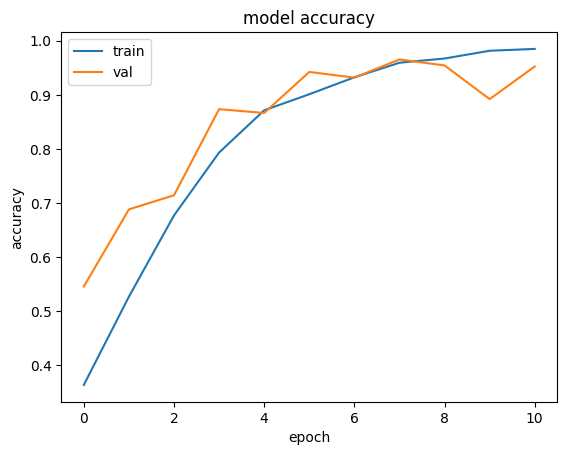

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

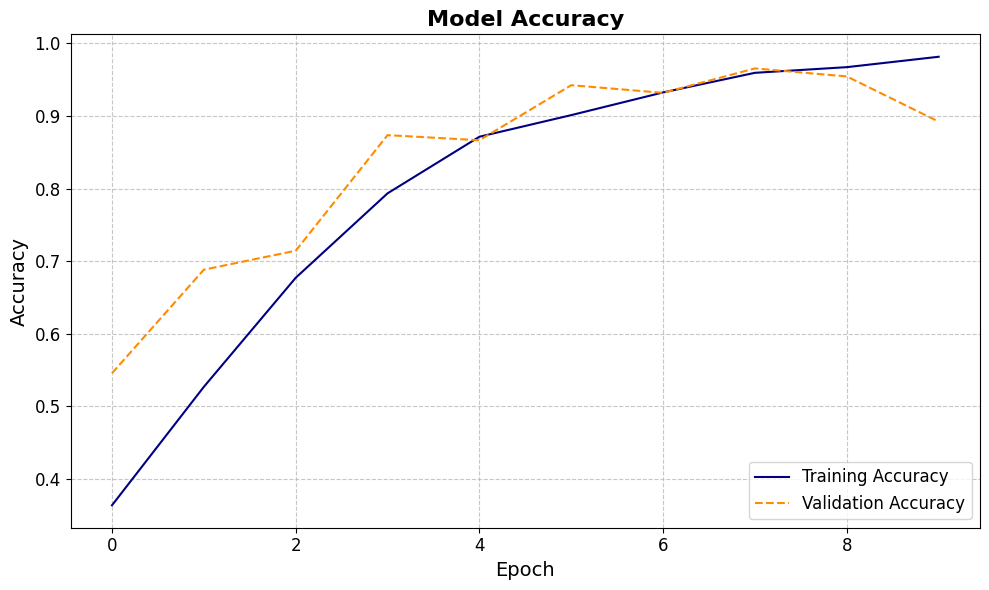

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
plt.plot(history.history['accuracy'], linestyle='-', color='navy', label='Training Accuracy')  # Solid line for training accuracy
plt.plot(history.history['val_accuracy'], linestyle='--', color='darkorange', label='Validation Accuracy')  # Dashed line for validation accuracy

# Enhance plot aesthetics
plt.title('Model Accuracy', fontsize=16, fontweight='bold')  # Add a descriptive title with increased font size and weight
plt.xlabel('Epoch', fontsize=14)  # Label x-axis with larger font size
plt.ylabel('Accuracy', fontsize=14)  # Label y-axis with larger font size
plt.xticks(fontsize=12)  # Increase tick label font size
plt.yticks(fontsize=12)  # Increase tick label font size
plt.legend(loc='lower right', fontsize=12)  # Adjust legend position and increase font size
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines with dashed style and reduced opacity
plt.tight_layout()  # Adjust layout to prevent overlapping elements

# Display the plot
plt.show()


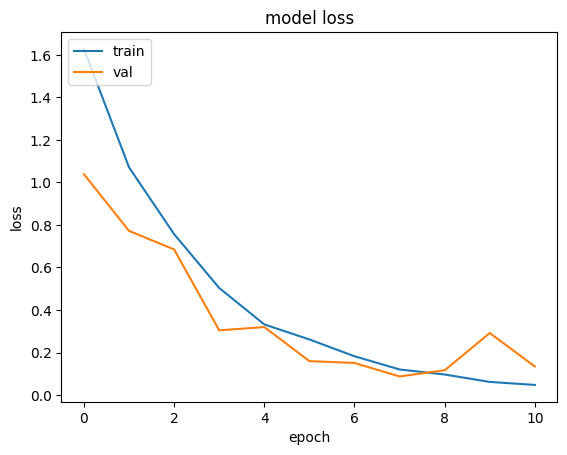

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

  EOSINOPHIL       0.99      0.87      0.93       781
  LYMPHOCYTE       1.00      1.00      1.00       764
    MONOCYTE       1.00      0.99      1.00       729
  NEUTROPHIL       0.87      0.99      0.93       714

    accuracy                           0.96      2988
   macro avg       0.97      0.96      0.96      2988
weighted avg       0.97      0.96      0.96      2988

Accuracy of the Model: 96.2%


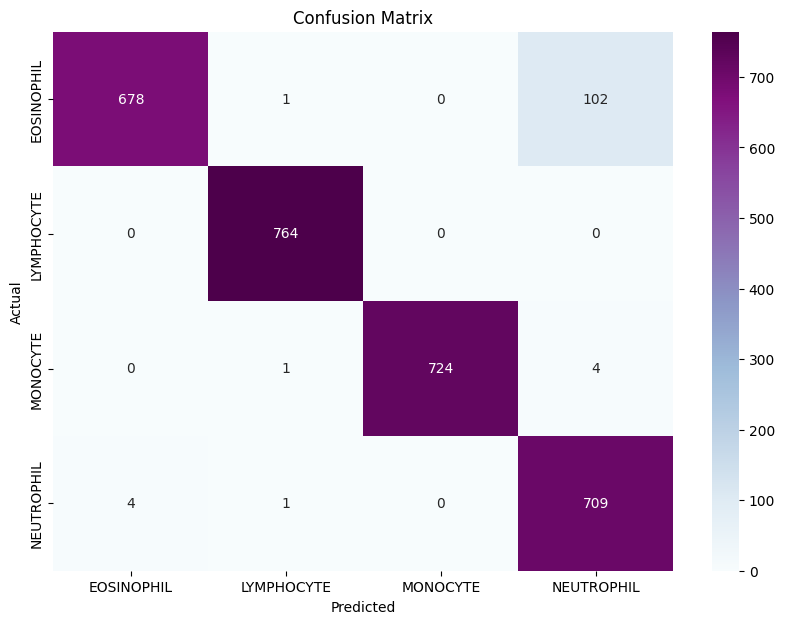

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='BuPu')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [ ]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
996/996 [==============================] - 76s 71ms/step - loss: 0.6958 - accuracy: 0.7198 - val_loss: 0.6229 - val_accuracy: 0.7570
Epoch 2/10
996/996 [==============================] - 82s 83ms/step - loss: 0.3780 - accuracy: 0.8513 - val_loss: 0.3617 - val_accuracy: 0.8489
Epoch 3/10
996/996 [==============================] - 78s 78ms/step - loss: 0.2694 - accuracy: 0.8937 - val_loss: 0.2931 - val_accuracy: 0.8830
Epoch 4/10
996/996 [==============================] - 60s 60ms/step - loss: 0.2106 - accuracy: 0.9207 - val_loss: 0.2490 - val_accuracy: 0.9086
Epoch 5/10
996/996 [==============================] - 63s 63ms/step - loss: 0.1666 - accuracy: 0.9382 - val_loss: 0.3413 - val_accuracy: 0.8825
Epoch 6/10
996/996 [==============================] - 67s 68ms/step - loss: 0.1376 - accuracy: 0.9483 - val_loss: 0.2416 - val_accuracy: 0.9081
Epoch 7/10
996/996 [==============================] - 67s 67ms/step - los

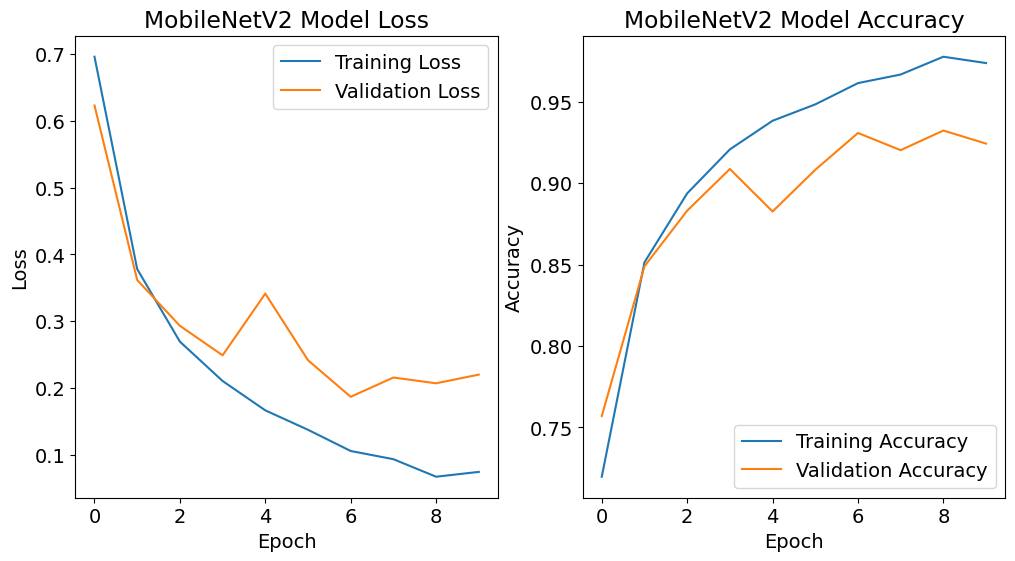

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define MobileNetV2 model
mobilenet_model = Sequential([
    MobileNetV2(include_top=False, pooling='avg', weights='imagenet'),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# Freeze MobileNetV2 layers
mobilenet_model.layers[0].trainable = False

# Compile MobileNetV2 model
mobilenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train MobileNetV2 model
mobilenet_history = mobilenet_model.fit(train, epochs=10, validation_data=val)
mobilenet_model.save("mobilenet_model.h5")

# Plot MobileNetV2 model training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mobilenet_history.history['loss'], label='Training Loss')
plt.plot(mobilenet_history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['accuracy'], label='Training Accuracy')
plt.plot(mobilenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
mobilenet_model.evaluate(test, verbose=1)

374/374 [==============================] - 20s 53ms/step - loss: 0.1713 - accuracy: 0.9388


[0.17134800553321838, 0.9387550354003906]

In [ ]:
mobilenet_model.save('mobilenet_model.h5')

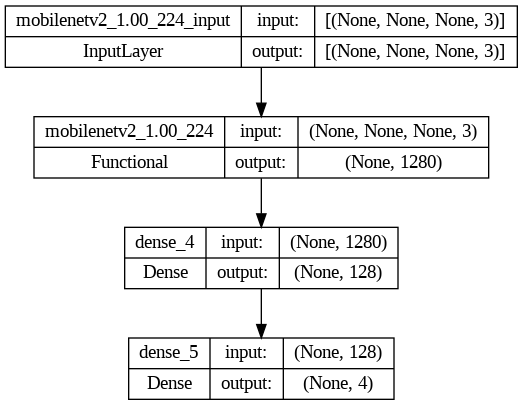

In [ ]:
from keras.utils import plot_model

plot_model(mobilenet_model, to_file='mobilenet_model.png', show_shapes=True, show_layer_names=True)

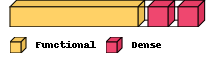

In [ ]:
import visualkeras

visualkeras.layered_view(mobilenet_model, scale_xy=5, legend=True)

##Resnet

In [ ]:
img_size = 224
batch_size = 32


train_datagen = ImageDataGenerator(rescale = 1/255.,brightness_range=[0.5,1.5], zoom_range=0.2,
                                   width_shift_range =0.15, height_shift_range =0.15, horizontal_flip=True )
val_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/ML_project/ML/dataset2-master/dataset2-master/images/TRAIN',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=True,
                                                   class_mode='sparse')

val_generator = val_datagen.flow_from_directory('/content/drive/MyDrive/ML_project/ML/dataset2-master/dataset2-master/images/TEST_SIMPLE',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='sparse')

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/ML_project/ML/dataset2-master/dataset2-master/images/TEST',
                                                   target_size = (img_size, img_size),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode = "sparse")

Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Add, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, InputLayer, GlobalAveragePooling2D ,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams['font.size'] = 14

In [ ]:
def residual_block(x, kernel_size, filters, s=2):
    f1,f2,f3 = filters
    x_shortcut = x

    # Shortcut Path
    x_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(s,s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    # Main Path
    # First Component
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Component
    x = Conv2D(f2, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third Component
    x = Conv2D(f3, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)

    return x

In [ ]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(64, kernel_size=(7,7), strides=(2,2))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)

x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])

x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])

# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])
# x = residual_block(x,3,[512,512,2048])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output_layer = Dense(4, activation='softmax')(x)

resnet50 = Model(inputs=input_layer,outputs=output_layer)

In [ ]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 109, 109, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 109, 109, 64)         256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 109, 109, 64)         0         ['batch_normalization_9[0]

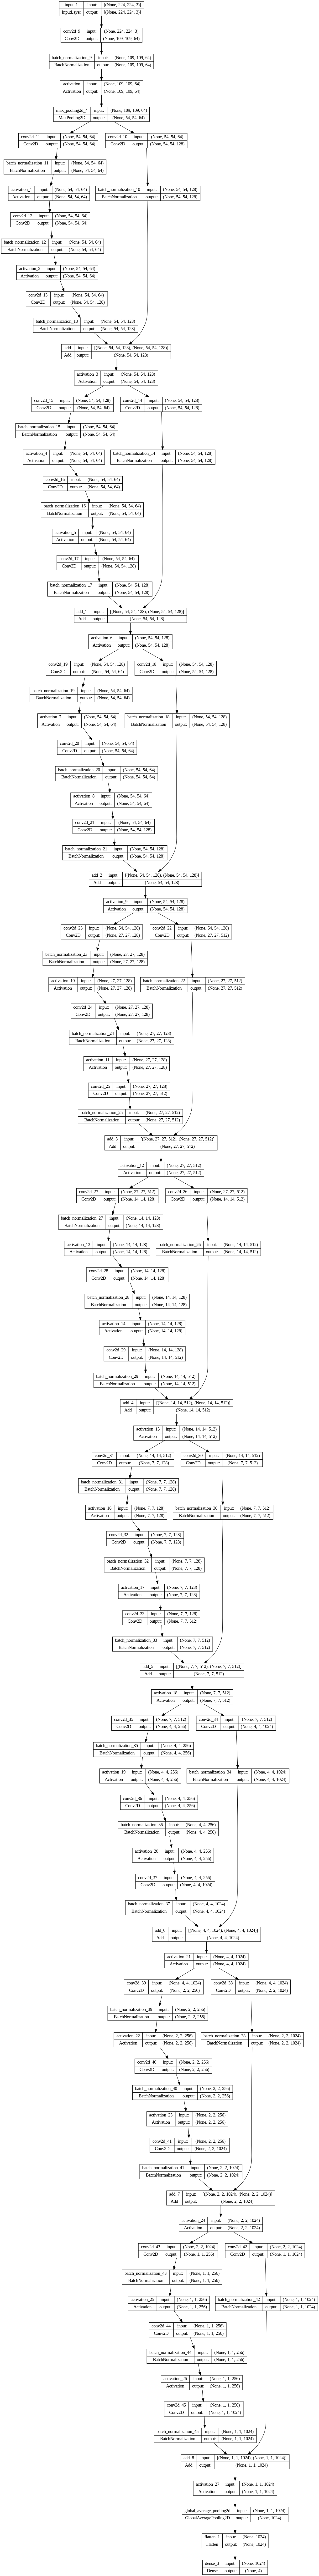

In [ ]:
from keras.utils import plot_model

plot_model(resnet50, to_file='resnet50.png', show_shapes=True, show_layer_names=True)

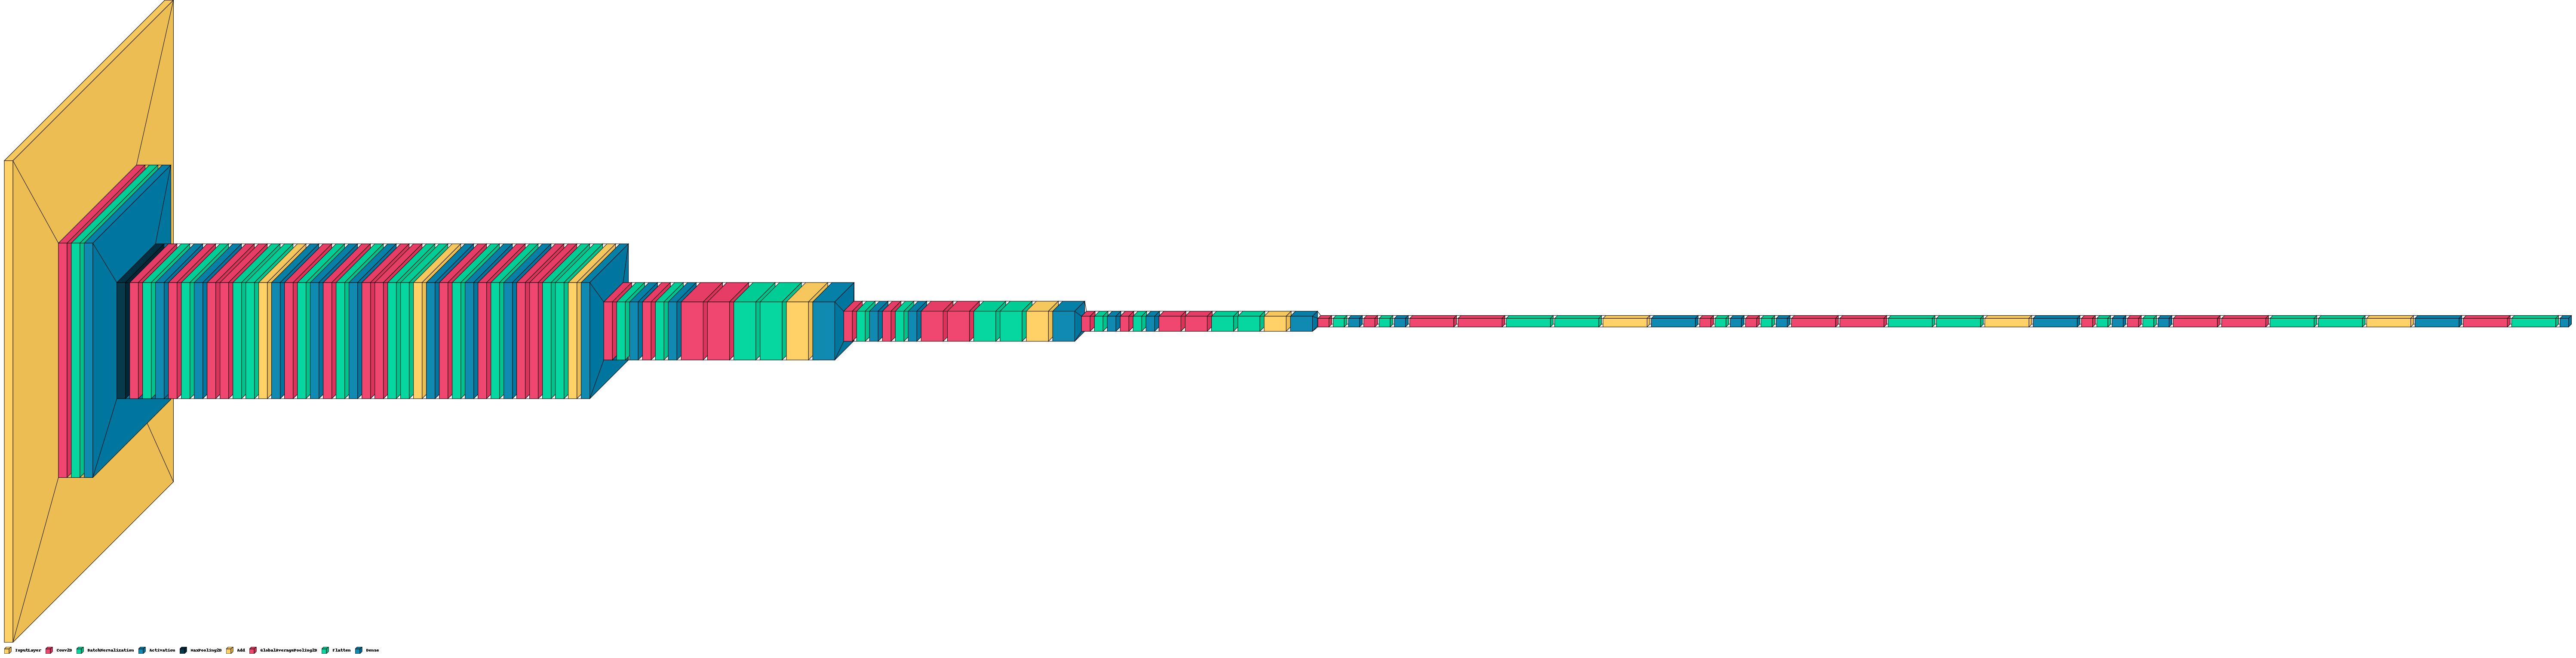

In [ ]:
import visualkeras

visualkeras.layered_view(resnet50, scale_xy=5, legend=True)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
# loss = tf.keras.losses.sparse_categorical_crossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Train the model
history_res = resnet50.fit(train_generator,
                        epochs=50,
                        validation_data=val_generator,
                        callbacks=[checkpoint,earlystopping])

Epoch 1/50
312/312 [==============================] - ETA: 0s - loss: 1.6689 - accuracy: 0.2605
Epoch 1: val_loss improved from inf to 1.40953, saving model to /tmp/checkpoint
312/312 [==============================] - 218s 563ms/step - loss: 1.6689 - accuracy: 0.2605 - val_loss: 1.4095 - val_accuracy: 0.1690
Epoch 2/50
312/312 [==============================] - ETA: 0s - loss: 1.5599 - accuracy: 0.2475
Epoch 2: val_loss improved from 1.40953 to 1.33370, saving model to /tmp/checkpoint
312/312 [==============================] - 172s 552ms/step - loss: 1.5599 - accuracy: 0.2475 - val_loss: 1.3337 - val_accuracy: 0.3944
Epoch 3/50
312/312 [==============================] - ETA: 0s - loss: 1.4790 - accuracy: 0.2586
Epoch 3: val_loss did not improve from 1.33370
312/312 [==============================] - 169s 541ms/step - loss: 1.4790 - accuracy: 0.2586 - val_loss: 1.3487 - val_accuracy: 0.2958
Epoch 4/50
312/312 [==============================] - ETA: 0s - loss: 1.4308 - accuracy: 0.2682


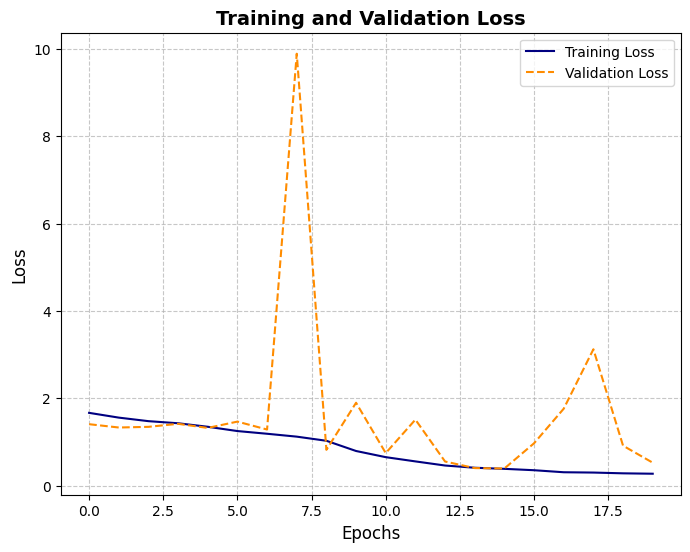

In [ ]:
import matplotlib.pyplot as plt

# Loss plot with improved aesthetics
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='navy', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange', linestyle='--')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()


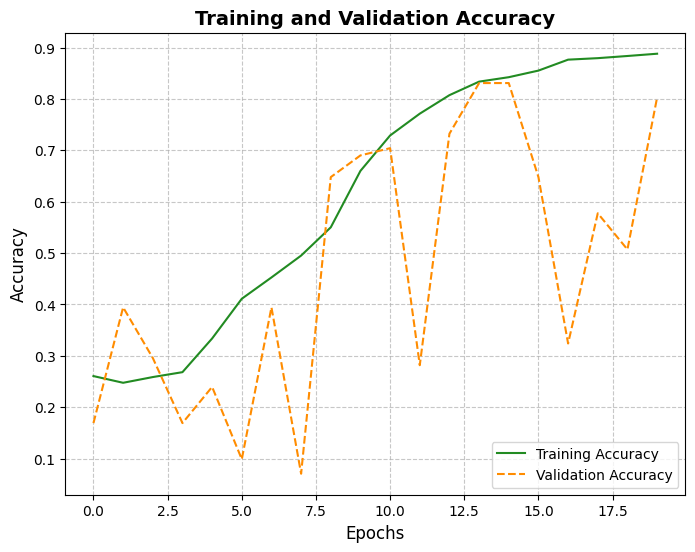

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot with improved aesthetics
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='forestgreen', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange', linestyle='--')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()


In [ ]:
y_pred = resnet50.predict(test_generator).round()
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

78/78 [==============================] - 12s 139ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis=1)


In [ ]:
print(classification_report(y_test,y_pred,target_names = class_labels))


              precision    recall  f1-score   support

  EOSINOPHIL       0.74      0.97      0.84       623
  LYMPHOCYTE       0.91      1.00      0.95       620
    MONOCYTE       0.91      0.78      0.84       620
  NEUTROPHIL       0.94      0.69      0.80       624

    accuracy                           0.86      2487
   macro avg       0.87      0.86      0.86      2487
weighted avg       0.87      0.86      0.86      2487



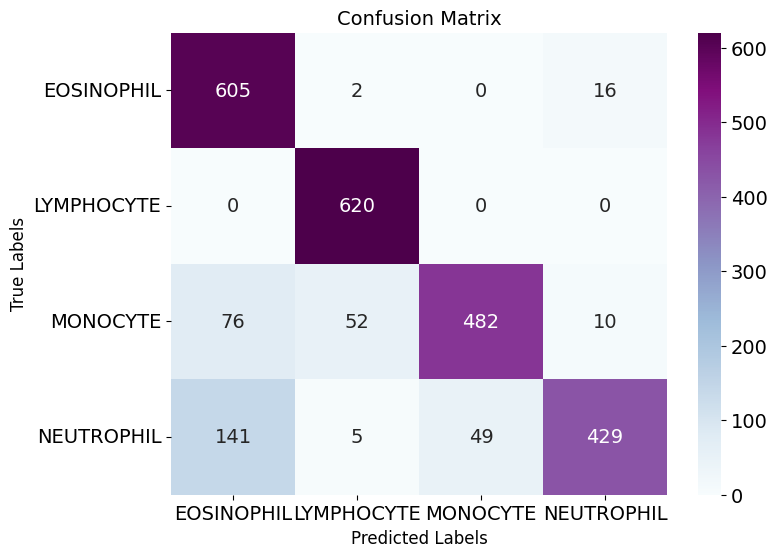

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='BuPu', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()


##Ensembling

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved models
cnn_model = load_model("Blood_Cell.h5")
mobilenet_model = load_model("mobilenet_model.h5")

# Make predictions using each model
cnn_pred = cnn_model.predict(test)
mobilenet_pred = mobilenet_model.predict(test)

# Combine the predictions using a simple voting mechanism
ensemble_pred = np.argmax(cnn_pred + mobilenet_pred, axis=1)

# Get the true labels
y_test = test.classes

# Evaluate the ensemble model
from sklearn.metrics import classification_report, accuracy_score

class_labels = list(test.class_indices.keys())
ensemble_report = classification_report(y_test, ensemble_pred, target_names=class_labels)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

print("Ensemble Model Classification Report:")
print(ensemble_report)
print("Ensemble Model Accuracy: {:.1f}%".format(ensemble_accuracy * 100))


374/374 [==============================] - 17s 44ms/step
Ensemble Model Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.98      0.97      0.98       781
  LYMPHOCYTE       1.00      1.00      1.00       764
    MONOCYTE       1.00      1.00      1.00       729
  NEUTROPHIL       0.96      0.98      0.97       714

    accuracy                           0.99      2988
   macro avg       0.99      0.99      0.99      2988
weighted avg       0.99      0.99      0.99      2988

Ensemble Model Accuracy: 98.7%


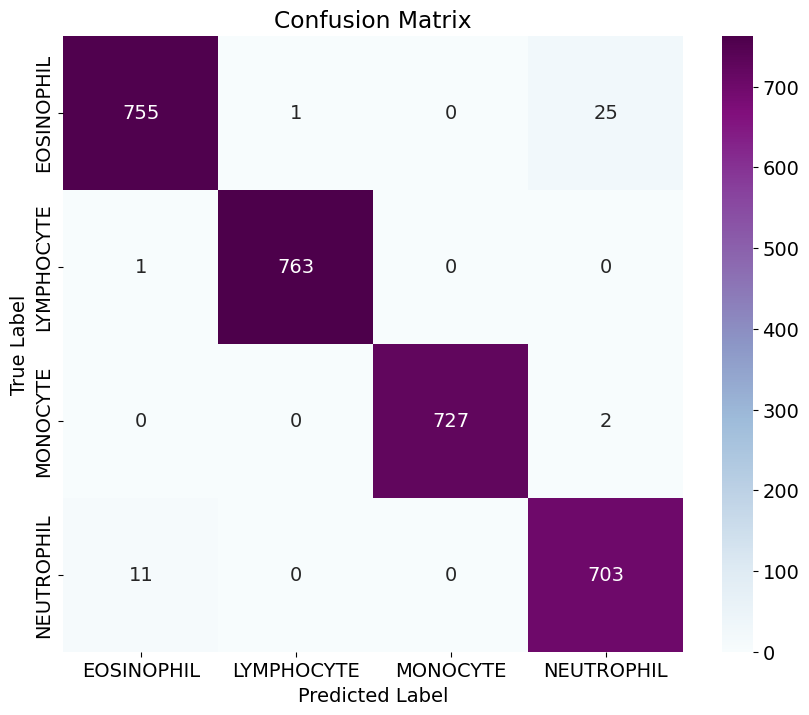

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, ensemble_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
